---
# Space Syntax analysis in Python

## 3. Analysis
---

For detailed explanation of the origins of this document read the first part "1. Basic functionality"

This part demonstrates how to do analysis using Python/Pandas and the depthmapXcli, a command-line interface of depthmapX. Python calls dethmapXcli to do analysis and does not require depthmapX itself. Beyond the libraries necessary for reading spatial and non-spatial data, a file that contains common functions is also loaded here to make the code easier to use

In [1]:
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '../commonFunctions'))
from depthmapXcli import (getDepthmapXcli, importLines, convertMap, axialAnalysis, 
                          getShapeGraph, segmentAnalysis, createGrid, fillGrid, VGA,
                          makeVGAGraph, getPointmapData, linkMapCoords, agentAnalysis)
from depthmapX import getAxmanesqueCMapLinear

import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygeos

/home/petros/.local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


---
### depthmapXcli: Axial analysis

A typical workflow when using depthmapX is to load line data, convert those lines to an axial map and then do axial analysis.

Let's load line data into a GRAPH file:

In [2]:
barnsburySmall = gpd.read_file("data/barnsbury/barnsbury_small_axial.mid")

importLines(barnsburySmall, "data/barnsburySmall.graph")

---
Then convert the line data inside the GRAPH file into an axial map and name that map "Axial Map"

In [3]:
convertMap("data/barnsburySmall.graph", newMapName = "Axial Map", newMapType = "axial")

---
Then carry out axial analysis for two radii, "n" and 3. We will also include choice, local metrics and intermediate metrics (RA, RRA).

In [4]:
axialAnalysis("data/barnsburySmall.graph", radii = ["n", "3"],
              includeChoice = True, includeLocal = True, includeIntermediateMetrics = False)

---
Finally, let's bring the data back into Python/GeoPandas using getShapeGraph() to read the GRAPH file and take a look at the column names of our new GeoDataFrame.

In [5]:
barnsburyAxialAnalysed = getShapeGraph("data/barnsburySmall.graph")
barnsburyAxialAnalysed.columns

Index(['Depthmap_Ref', 'Choice', 'Choice_R3', 'Choice_Norm_', 'Choice_Norm_R3',
       'Connectivity', 'Control', 'Controllability', 'Data_Map_Ref', 'Entropy',
       'Entropy_R3', 'Harmonic_Mean_Depth', 'Harmonic_Mean_Depth_R3',
       'Integration_HH_', 'Integration_HH_R3', 'Integration_P_value_',
       'Integration_P_value_R3', 'Integration_Tekl_', 'Integration_Tekl_R3',
       'Intensity', 'Intensity_R3', 'Line_Length', 'Mean_Depth',
       'Mean_Depth_R3', 'Node_Count', 'Node_Count_R3', 'Relativised_Entropy',
       'Relativised_Entropy_R3', 'geometry'],
      dtype='object')

---
Let's plot the newly analysed map, this time using one of depthmap's palettes, provided by the package (Axmanesque is the default palette in depthmapX). We will also make the background of the map black using par(bg = "black").

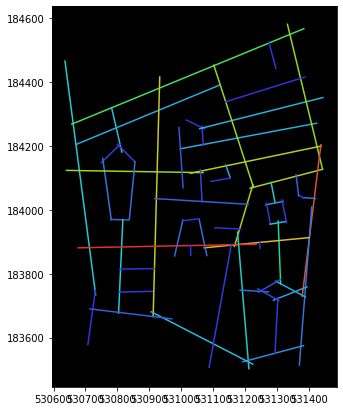

In [6]:
axmanesqueCMap = getAxmanesqueCMapLinear()

fig = plt.figure(figsize=(7,7))
ax = plt.axes()
ax.set_facecolor("black")
barnsburyAxialAnalysed.plot("Choice", cmap=axmanesqueCMap, ax = ax)
plt.show()

---
### depthmapXcli: Segment analysis

To carry out segment analysis, here we first convert the axial map to a segment map and then do segment analysis using three radii, "n", 50 and 100. The radius type used is "metric". As previously .columns will give us the column names of our new Lines GeoDataFrame.

In [7]:
convertMap("data/barnsburySmall.graph", "data/barnsburySegment.graph",
                      newMapName = "Segment map", newMapType = "segment",
                      stubLengthToRemove = 40, copyAttributes = True)
segmentAnalysis("data/barnsburySegment.graph", analysisType = "tulip",
                           radii = ["n", "50", "100"], radiusType = "metric",
                           tulipBins = 1024, includeChoice = True,
                           weightWithColumn = "Segment Length")
segmentAnalysed = getShapeGraph("data/barnsburySegment.graph")
segmentAnalysed.columns

Index(['Depthmap_Ref', 'Angular_Connectivity', 'Axial_Choice',
       'Axial_Choice_R3', 'Axial_Choice_Norm_', 'Axial_Choice_Norm_R3',
       'Axial_Connectivity', 'Axial_Control', 'Axial_Controllability',
       'Axial_Data_Map_Ref', 'Axial_Entropy', 'Axial_Entropy_R3',
       'Axial_Harmonic_Mean_Depth', 'Axial_Harmonic_Mean_Depth_R3',
       'Axial_Integration_HH_', 'Axial_Integration_HH_R3',
       'Axial_Integration_P_value_', 'Axial_Integration_P_value_R3',
       'Axial_Integration_Tekl_', 'Axial_Integration_Tekl_R3',
       'Axial_Intensity', 'Axial_Intensity_R3', 'Axial_Line_Length',
       'Axial_Line_Ref', 'Axial_Mean_Depth', 'Axial_Mean_Depth_R3',
       'Axial_Node_Count', 'Axial_Node_Count_R3', 'Axial_Relativised_Entropy',
       'Axial_Relativised_Entropy_R3', 'Connectivity', 'Segment_Length',
       'T1024_Choice', 'T1024_Choice_R100_00_metric',
       'T1024_Choice_R50_00_metric', 'T1024_Choice_Segment_Length_Wgt',
       'T1024_Choice_Segment_Length_W_1', 'T1024_Choic

---
Let's then plot the segment map

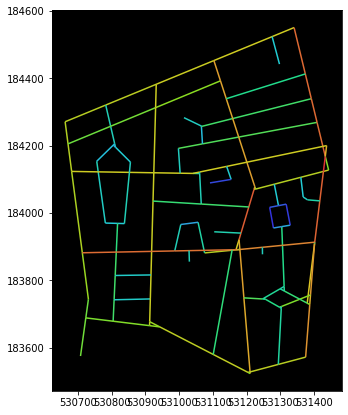

In [8]:
axmanesqueCMap = getAxmanesqueCMapLinear()

fig = plt.figure(figsize=(7,7))
ax = plt.axes()
ax.set_facecolor("black")
segmentAnalysed.plot("T1024_Integration", cmap=axmanesqueCMap, ax = ax)
plt.show()

---
### depthmapXcli: Visibility Graph Analysis

Finally, we may perform VGA directly from Python, by loading a floorplan into a graph, file, defining and filling a grid and carrying out the analysis.

The next chunk loads and plots a simplified National Gallery plan provided here as a pair of MIF/MID files.

<AxesSubplot:>

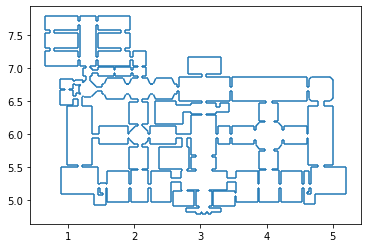

In [9]:
galleryLines = gpd.read_file("data/gallery/gallery_lines.mid")
galleryLines.plot()

---
The next chunk imports the gallery Lines GeoDataFrame into a GRAPH file, creates a grid with a cell size of 0.04, fills the grid starting from the point 2.86, 6.69 and then makes the graph. Finally, the VGA data is imported into Python using getPointmapData() and plotted.

In [10]:
importLines(galleryLines, "data/gallery/gallery.graph")
convertMap("data/gallery/gallery.graph", newMapName = "Plan", newMapType = "drawing")
createGrid("data/gallery/gallery.graph", gridSize = 0.04)
fillGrid("data/gallery/gallery.graph", fillX = 2.86, fillY = 6.68)
makeVGAGraph("data/gallery/gallery.graph")
galleryVGA = getPointmapData("data/gallery/gallery.graph")
galleryVGA.columns

Index(['i', 'j', 'Ref', 'Point Second Moment', 'Point First Moment', 'coords',
       'Connectivity'],
      dtype='object')

<AxesSubplot:>

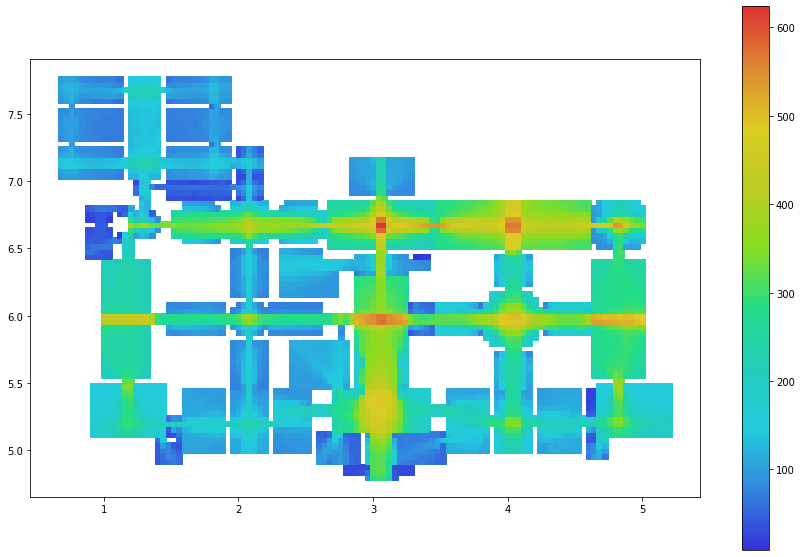

In [11]:
axmanesqueCMap = getAxmanesqueCMapLinear()

galleryVGA.plot("Connectivity", cmap=axmanesqueCMap, marker='s', markersize=33, legend=True, figsize=(15, 10))

---
We may also link coordinates (if for example we have different floors):

In [12]:
linkMapCoords("data/gallery/gallery.graph",
              linkFromX = 4.81, linkFromY = 6.67,
              linkToX = 2.39, linkToY = 5.23,
              mapTypeToLink = "pointmaps")


In [13]:
VGA("data/gallery/gallery.graph", vgaMode = "visibility-global", radii = ["n"])
VGA("data/gallery/gallery.graph", vgaMode = "isovist", radii = ["n"])
galleryVGA = getPointmapData("data/gallery/gallery.graph")
galleryVGA.columns

Index(['i', 'Visual Node Count', 'j', 'Isovist Min Radial',
       'Isovist Drift Magnitude', 'Visual Entropy',
       'Visual Integration [P-value]', 'Isovist Drift Angle',
       'Point First Moment', 'coords', 'Isovist Occlusivity', 'Isovist Area',
       'Visual Relativised Entropy', 'Visual Integration [Tekl]',
       'Isovist Perimeter', 'Visual Mean Depth', 'Isovist Compactness', 'Ref',
       'Point Second Moment', 'Visual Integration [HH]', 'Connectivity',
       'Isovist Max Radial'],
      dtype='object')

<AxesSubplot:>

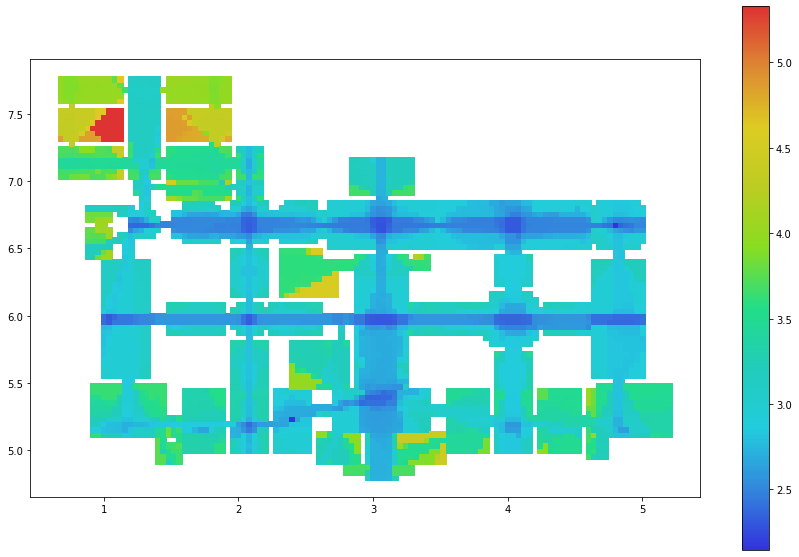

In [14]:
galleryVGA.plot("Visual Mean Depth", cmap=axmanesqueCMap, marker='s', markersize=33, legend=True, figsize=(15, 10))

---
We may also carry out Agent analysis after we have the grid using the command agentAnalysis():

In [15]:
agentAnalysis("data/gallery/gallery.graph", lookMode = "standard", timesteps = 5000, releaseRate = 0.1, agentFOV = 16, agentSteps = 3, agentLife = 500)
galleryAgents = getPointmapData("data/gallery/gallery.graph")
galleryAgents.columns

Index(['i', 'Visual Node Count', 'j', 'Isovist Min Radial',
       'Isovist Drift Magnitude', 'Gate Counts', 'Visual Entropy',
       'Visual Integration [P-value]', 'Isovist Drift Angle',
       'Point First Moment', 'coords', 'Isovist Occlusivity', 'Isovist Area',
       'Visual Relativised Entropy', 'Visual Integration [Tekl]',
       'Isovist Perimeter', 'Visual Mean Depth', 'Isovist Compactness', 'Ref',
       'Point Second Moment', 'Visual Integration [HH]', 'Connectivity',
       'Isovist Max Radial'],
      dtype='object')

<AxesSubplot:>

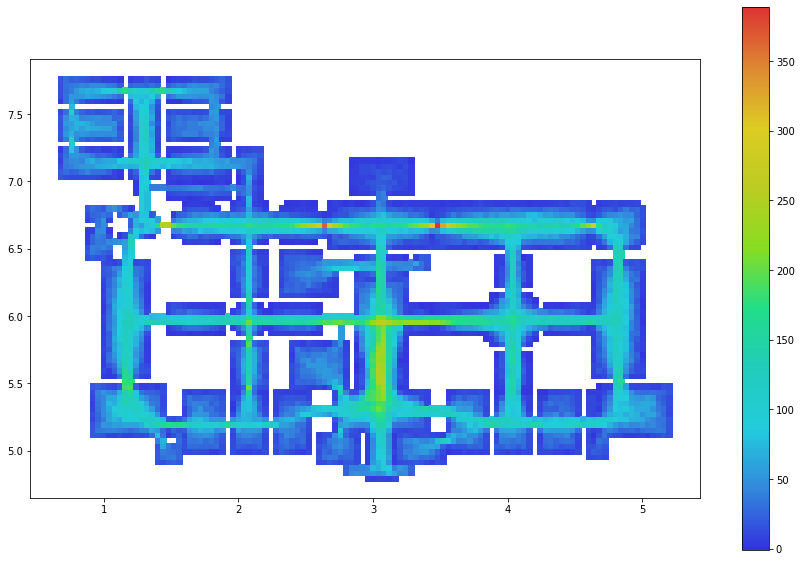

In [16]:
galleryAgents.plot("Gate Counts", cmap=axmanesqueCMap, marker='s', markersize=33, legend=True, figsize=(15, 10))

---
## Statistics

### Simple aggregates

Finally, we will load some room data to compare to the VGA. More spcifically we will test the average Visual Mean Depth of two galleries. First let's load the galleries as a SpatialPolygonsDataFrame:

<AxesSubplot:>

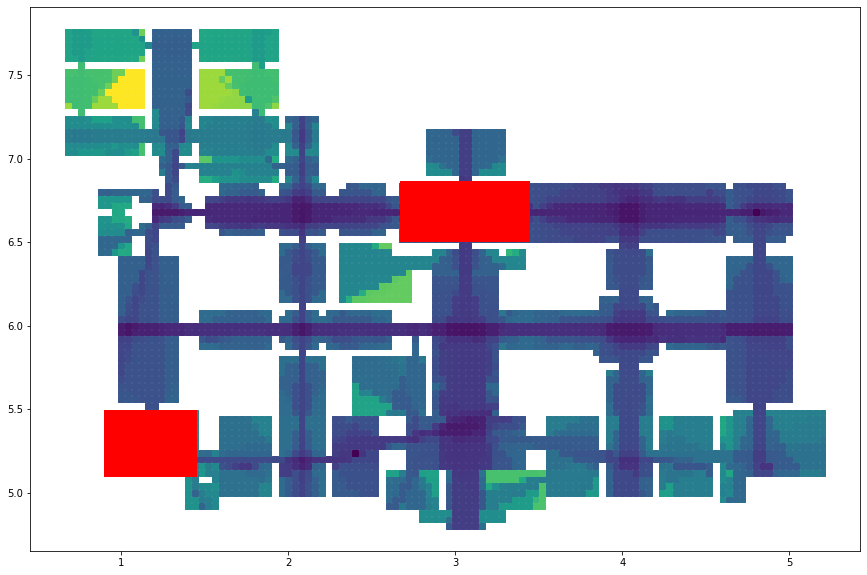

In [17]:
galleryFunction = gpd.read_file("data/gallery/gallery_polys.mid")


fig, ax = plt.subplots(figsize=(15, 10))

galleryVGA.plot("Visual Mean Depth", ax = ax, marker='s', markersize=33)
galleryFunction.plot(color = "red", ax = ax)

---
Then, let's calculate which pixels overlap with which polygons, and aggregate per polygon. The resulting table is the average Visual Mean Depth of each gallery. More information on gpd.overlay() may be found [here](https://geopandas.org/en/stable/docs/reference/api/geopandas.overlay.html).

In [18]:
overlapsDF = gpd.overlay(galleryVGA, galleryFunction, how='intersection')
overlapsDF.groupby('layer')['Visual Mean Depth'].aggregate("mean")

layer
acc-gallery1    3.244835
acc-gallery2    2.727843
Name: Visual Mean Depth, dtype: float64

---
In the same vain, let's load some observed activity data and do a similar aggregation:
First let's load the snapshot data as a SpatialPointsDataFrame and add it to the plot as white dots.

<AxesSubplot:>

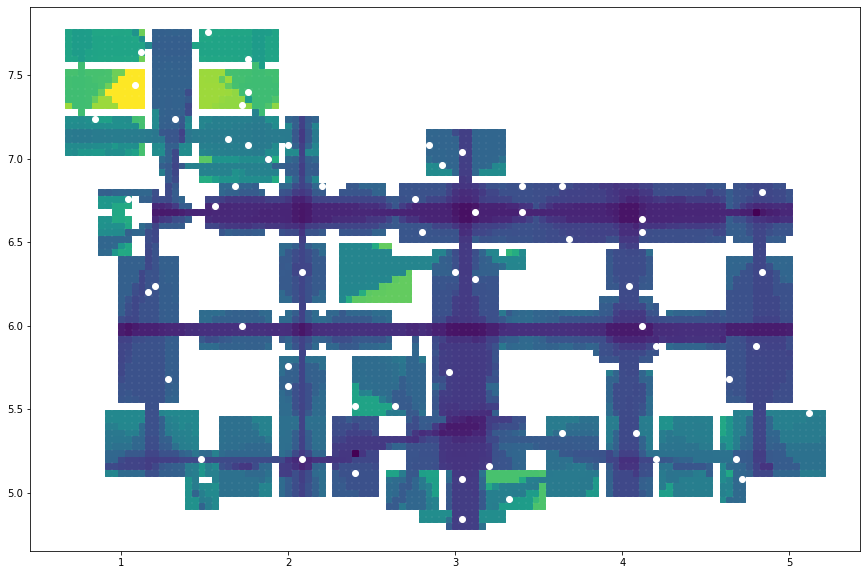

In [19]:
gallerySnapshot = gpd.read_file("data/gallery/gallery_snapshot.mid")

fig, ax = plt.subplots(figsize=(15, 10))

galleryVGA.plot("Visual Mean Depth", ax = ax, marker='s', markersize=33)
gallerySnapshot.plot(color = "white", ax = ax)


---
And then let's find the number of people in each gallery per activity:

In [20]:
overlapsDF = gpd.overlay(gallerySnapshot, galleryFunction, how='intersection')
overlapsDF.groupby(['layer', 'activity']).aggregate("count")

,,layertype,block,colour,geometry
layer,activity,,,,
acc-gallery2,standing,5,5,5,5


---
### Simple correlation

To carry out simple correlation we'll first load the large barnsbury axial map, convert it to a segment and compare it to gatecounts:

First the segment map:

In [21]:
barnsburyAxial = gpd.read_file("data/barnsbury/barnsbury_axial.mid")
gateCounts = gpd.read_file("data/barnsbury/barnsbury_ped_gatecounts.mid")

importLines(barnsburyAxial, "data/barnsburyAxial.graph")
convertMap("data/barnsburyAxial.graph", 
                      newMapName = "Axial Map", newMapType = "axial")
convertMap("data/barnsburyAxial.graph", "data/barnsburySegment.graph",
                      newMapName = "Segment map", newMapType = "segment",
                      stubLengthToRemove = 40, copyAttributes = True)
segmentAnalysis("data/barnsburySegment.graph", analysisType = "tulip",
                           radii = ["n", "50", "100"], radiusType = "metric",
                           tulipBins = 1024, includeChoice = True,
                           weightWithColumn = "Segment Length")
segmentAnalysed = getShapeGraph("data/barnsburySegment.graph")

---
Plot the segment map with the gatecounts loaded earlier

<AxesSubplot:>

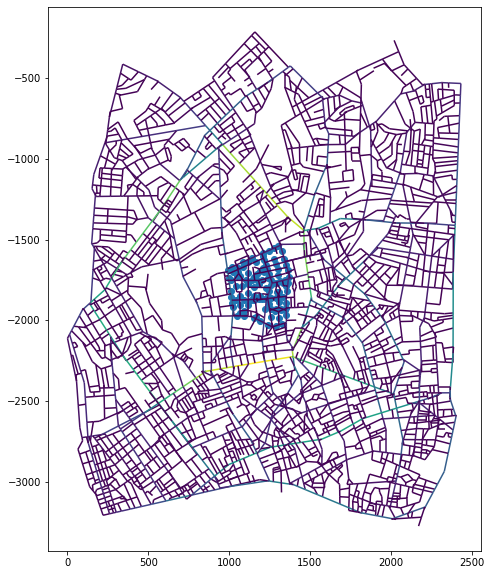

In [22]:
axmanesqueCMap = getAxmanesqueCMapLinear()

fig, ax = plt.subplots(figsize=(15, 10))

segmentAnalysed.plot("T1024_Choice", ax=ax)
gateCounts.plot(ax=ax)

In [23]:
segmentAnalysed.crs = None
gateCounts.crs = None
gateCountsAnalysed = gpd.sjoin_nearest(gateCounts, segmentAnalysed)
gateCountsAnalysed.head(5)

,ID,Area_Name,Gate_No,Axial_Map,LineID,X,Y,mov_ped_ph,landuse,trafmanage,...,T1024_Node_Count_R50_00_metric,T1024_Total_Depth,T1024_Total_Depth_R100_00_metri,T1024_Total_Depth_R50_00_metric,T1024_Total_Depth_Segment_Lengt,T1024_Total_Depth_Segment_Len_1,T1024_Total_Depth_Segment_Len_2,T1024_Total_Segment_Length,T1024_Total_Segment_Length_R100,T1024_Total_Segment_Length_R50_
0,1,Barnsbury,1,Barnsbury,3,1017.248,-1669.215,104,residential,twoway,...,6.0,26133.500,31.960938,3.980469,796071.19,968.46301,72.329872,215869.97,757.35779,138.516080
1,2,Barnsbury,2,Barnsbury,3,1084.500,-1639.305,88,residential,twoway,...,5.0,26128.184,19.234375,1.570312,795940.69,240.47760,24.278835,215869.97,427.34085,118.993740
2,3,Barnsbury,3,Barnsbury,3,1144.725,-1612.515,114,residential,twoway,...,10.0,26081.980,17.707031,8.257812,794282.62,663.61237,150.033430,215869.97,684.46558,222.010930
3,4,Barnsbury,6,Barnsbury,3,1209.915,-1583.525,144,residential,twoway,...,6.0,26036.453,9.730469,2.011719,793124.38,530.05469,102.695530,215869.97,626.21411,218.297930
4,5,Barnsbury,7,Barnsbury,3,1244.630,-1568.085,134,school,twoway,...,3.0,26034.074,13.546875,0.000000,793035.12,371.26303,0.000000,215869.97,551.09039,91.088219


---
A simple linear model can then be carried out using the statsmodel library to create the model and summary of the statistics.


In [24]:
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import abline_plot

In [25]:
mod = sm.OLS(gateCountsAnalysed['mov_ped_ph'], gateCountsAnalysed['T1024_Choice'])
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:             mov_ped_ph   R-squared (uncentered):                   0.807
Model:                            OLS   Adj. R-squared (uncentered):              0.805
Method:                 Least Squares   F-statistic:                              450.7
Date:                Tue, 15 Mar 2022   Prob (F-statistic):                    2.43e-40
Time:                        13:02:50   Log-Likelihood:                         -588.02
No. Observations:                 109   AIC:                                      1178.
Df Residuals:                     108   BIC:                                      1181.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

---
[here](https://www.statsmodels.org/dev/examples/index.html#plotting)

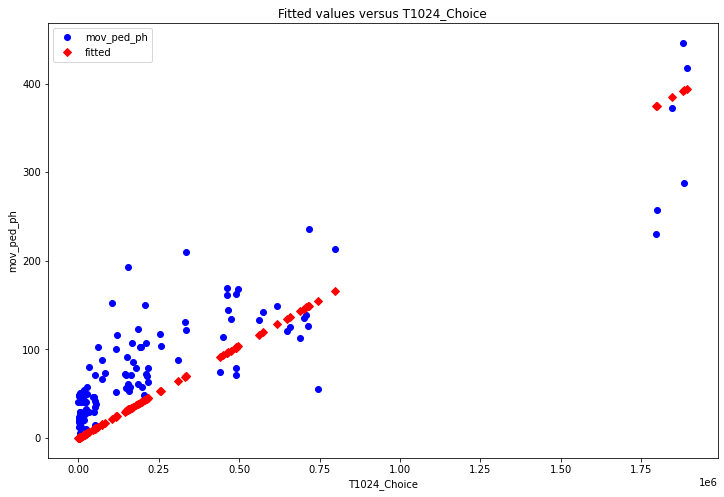

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(res, 'T1024_Choice', ax=ax,vlines = None)
plt.show()

---
Multiple regression may also be carried out by adding more columns to the model

In [27]:
mod = sm.OLS(gateCountsAnalysed['mov_ped_ph'],
             gateCountsAnalysed[['T1024_Choice', "T1024_Integration"]])
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:             mov_ped_ph   R-squared (uncentered):                   0.906
Model:                            OLS   Adj. R-squared (uncentered):              0.905
Method:                 Least Squares   F-statistic:                              518.4
Date:                Tue, 15 Mar 2022   Prob (F-statistic):                    8.92e-56
Time:                        13:02:50   Log-Likelihood:                         -548.47
No. Observations:                 109   AIC:                                      1101.
Df Residuals:                     107   BIC:                                      1106.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------